# DATA ANALYSIS COUNT

Colouring the embedding space based on the frequency of locations in sequences. 


In [1]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap
import numpy as np
import csv
import matplotlib.pyplot as plt


In [2]:
# model=word2vec.Word2Vec.load('../Data/Models/word2vec_epoch_1000_min_1.model')
#model=word2vec.Word2Vec.load('../Data/Models/best_model.model')
model=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_100d.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_300d.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_2000e.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/best_model_100_dim_5e.model')

In [3]:
with open('../Data/sequences.csv', 'r') as f:
    reader = csv.reader(f)
    sequences = list(reader)

In [4]:
X = model.wv.vectors

In [5]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [6]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")


In [7]:
# Create a dictionary to map addresses to their corresponding embeddings
journey_embeddings = {}
for journey in sequences:
    for place in journey:
        try:
            journey_id = place  # Convert the journey list to a tuple to use as a dictionary key
            journey_embeddings[journey_id] = model.wv[journey_id]
        except KeyError:
            # Handle cases where the journey is not present in the Word2Vec model
            pass

# Convert dictionary to numpy array
X = np.array(list(journey_embeddings.values()))

# Create a list of all addresses
journey_ids = list(journey_embeddings.keys())

# Create a dictionary mapping addresses to their index in the numpy array
journey_idx = {journey_id: idx for idx, journey_id in enumerate(journey_ids)}

In [8]:
print(len(journey_ids)) #number of unique locations is 3751

3751



____________________________________________________________________________________________________________________________________________________



















# Plots with count

In [9]:
counts_to_labels = {100: '0-100', 1000: '101-1000', 5000: '1001-5000', 10000: '5001-10000', 50000: '10000-50000', 100000: '50001-100000', 1000001: '100000+'}


In [10]:
address_count_seq = {}
for seq in sequences:
    for place in seq:
        if place in address_count_seq:
            address_count_seq[place] += 1
        else:
            address_count_seq[place] = 1


from collections import Counter

# Count occurrences of each number of mentions of addresses. So counting how many addresses was mentioned once and so on
address_counts = Counter(address_count_seq.values())

# Sort the counts by their keys (number of mentions), in descending order
sorted_counts = sorted(address_counts.items(), key=lambda x: x[0], reverse=True)

In [11]:

address_cluster_count = {}

for address in address_count_seq.keys():
      count = address_count_seq[address]
      if 0 <= count <= 100:
         address_cluster_count[address] = 100
      elif 101 <= count <= 1000:
         address_cluster_count[address] = 1000
      elif 1001 <= count <= 5000:
         address_cluster_count[address] = 5000
      elif 5001 <= count <= 10000:
         address_cluster_count[address] = 10000
      elif 10001 <= count <= 50000:
         address_cluster_count[address] = 50000
      elif 50001 <= count <= 100000:
         address_cluster_count[address] = 100000
      elif 100001 <= count:
         address_cluster_count[address] = 1000001
      else:
         print("address was: ", address)
         address_cluster_count[address] = 0 


In [12]:
from collections import Counter

# Count occurrences of each zip code
count_counts = Counter(address_cluster_count.values())

# Print the zip code counts
for occurrence, count in sorted(count_counts.items()):
    print(f"Count {occurrence}: {count} occurrences")

Count 100: 4063 occurrences
Count 1000: 833 occurrences
Count 5000: 265 occurrences
Count 10000: 57 occurrences
Count 50000: 76 occurrences
Count 100000: 22 occurrences
Count 1000001: 9 occurrences


{100: '#ffe119', 1000: '#f58231', 5000: '#3cb44b', 10000: '#42d4f4', 50000: '#4363d8', 100000: '#f032e6', 1000001: '#e6194b'}


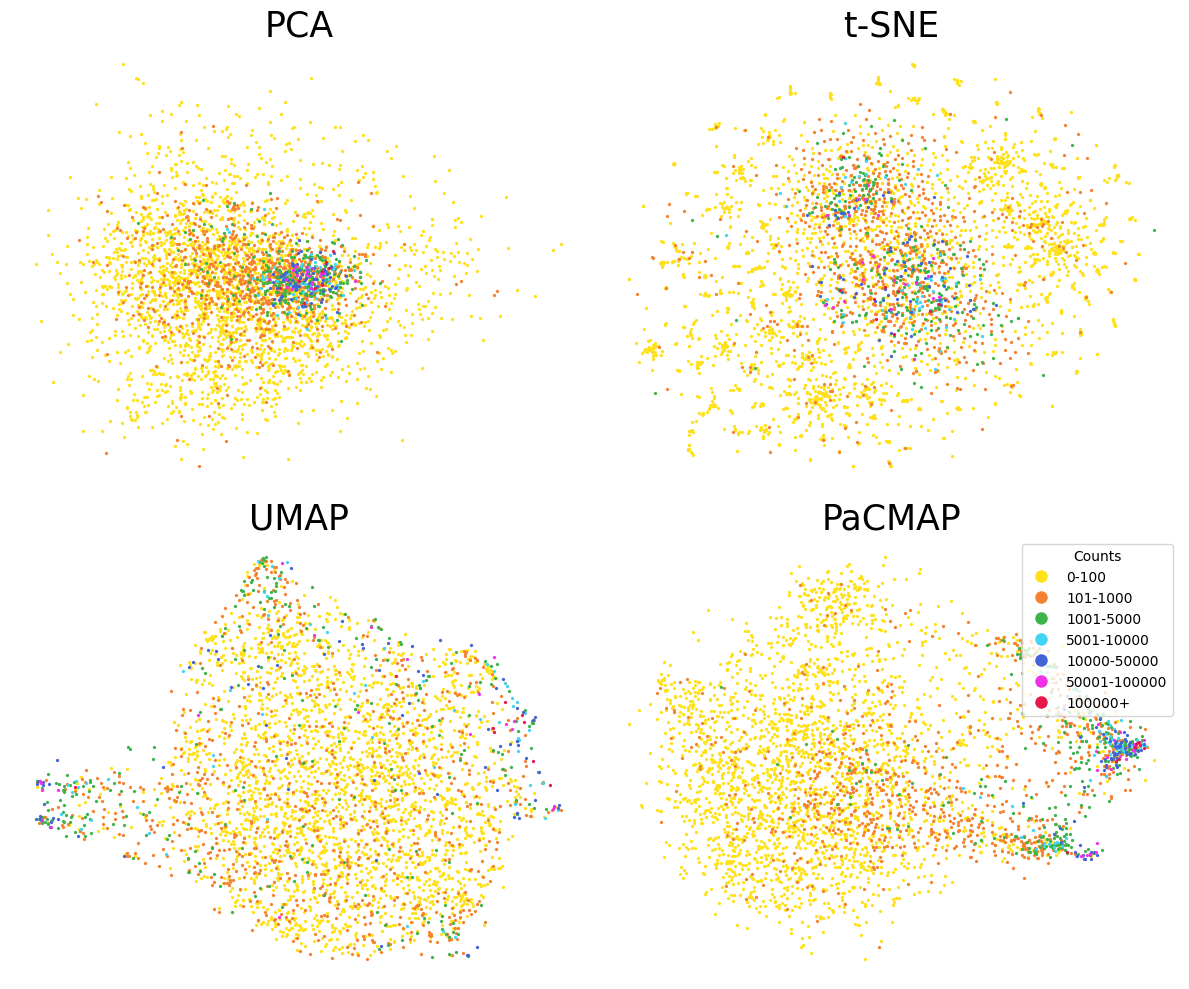

In [13]:

# Define color palette for zip codes
count_colors = {}  # Dictionary to map zip codes to colors
unique_count_codes = sorted(counts_to_labels.keys())
num_colors = len(unique_count_codes) #change this
#color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
color_palette = ['#ffe119', '#f58231', '#3cb44b', '#42d4f4', '#4363d8', '#f032e6', '#e6194b']
#print("number of unique zips: ", num_colors)

for idx, count_code in enumerate(unique_count_codes):
    count_colors[count_code] = color_palette[idx]

print(count_colors)
# Create the plots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
xs = [proj_2, proj, proj_1, proj_3]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

for row in ax:
    for col in row:
        col.set_title(ts[s], fontsize=25)

        for current_count_code in unique_count_codes:
            relevant_addresses = []
            for address, count_code in address_cluster_count.items():
                if address in journey_ids:
                    if current_count_code == count_code:
                        relevant_addresses.append(address)

            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_count_code, c=count_colors[current_count_code]
            )
        #  # Add labels to stations makes it impossible to read 
        #     for journey_id in relevant_journeys_zip:
        #         x_coord = xs[s][journey_idx[journey_id]][0]
        #         y_coord = xs[s][journey_idx[journey_id]][1]
        #         col.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed
            
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=count_colors[count_code], label=counts_to_labels[count_code]) for count_code in unique_count_codes]
plt.legend(handles=handles, title='Counts')

fig.tight_layout()
plt.show()


______________________________________________________________________________________________________________________________________

# CHOOSING MODEL AND DIMENSIONS


In [134]:
model_10000_100=word2vec.Word2Vec.load('../Data/Models/model_10000e_100d.model')
model_10000_100_lowest=word2vec.Word2Vec.load('../Data/Models/model_10000e_100d_lowest_loss.model')
model_2000_300=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') 
model_2000_100=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_2000e.model')
model_50_300=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_300d.model')
model_50_100=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_100d.model')
model_10_100= word2vec.Word2Vec.load('../Data/Models/model_10e_100d.model')
model_5_100= word2vec.Word2Vec.load('../Data/Models/model_5e_100d.model')
model_2_100= word2vec.Word2Vec.load('../Data/Models/model_2e_100d.model')
model_1_100= word2vec.Word2Vec.load('../Data/Models/model_1e_100d.model')

In [135]:
X = model_2000_300.wv.vectors
embedding_2000_300 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2000_300 = embedding_2000_300.fit_transform(X, init="pca")

X1 = model_50_100.wv.vectors
embedding_50_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_50_100 = embedding_50_100.fit_transform(X1, init="pca")

X2 = model_50_300.wv.vectors
embedding_50_300 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_50_300 = embedding_50_300.fit_transform(X2, init="pca")

X3 = model_2000_100.wv.vectors
embedding_2000_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2000_100 = embedding_2000_100.fit_transform(X3, init="pca")

X4 = model_10000_100_lowest.wv.vectors
embedding_10000_100_lowest = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10000_100_lowest = embedding_10000_100_lowest.fit_transform(X4, init="pca")

X5 = model_10000_100.wv.vectors
embedding_10000_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10000_100 = embedding_10000_100.fit_transform(X5, init="pca")

X6 = model_5_100.wv.vectors
embedding_5_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_5_100 = embedding_5_100.fit_transform(X6, init="pca")

X7 = model_2_100.wv.vectors
embedding_2_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2_100 = embedding_2_100.fit_transform(X7, init="pca")

X8 = model_1_100.wv.vectors
embedding_1_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_1_100 = embedding_1_100.fit_transform(X8, init="pca")

X9 = model_10_100.wv.vectors
embedding_10_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10_100 = embedding_10_100.fit_transform(X9, init="pca")



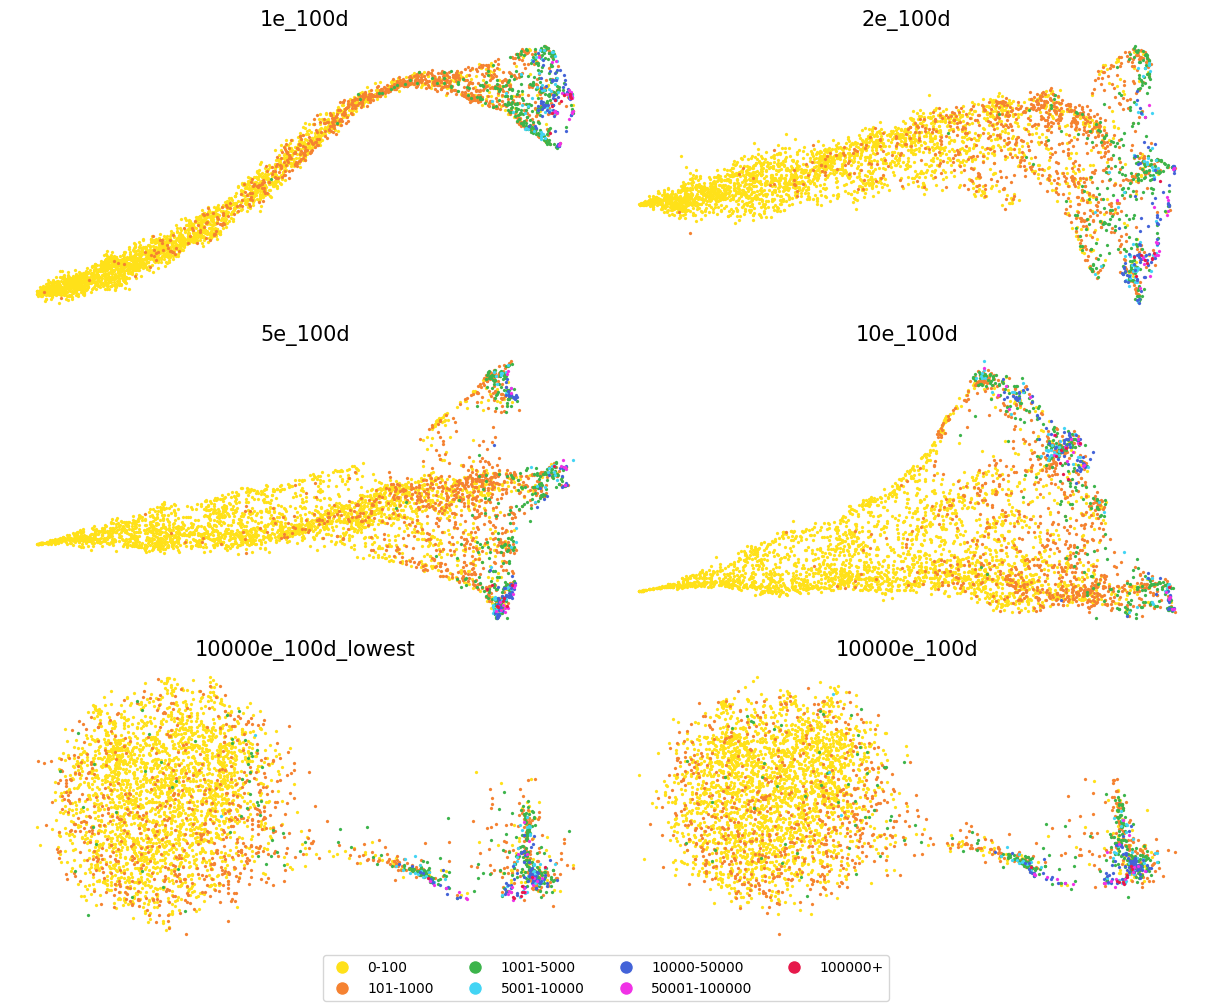

In [136]:
# Define color palette for zip codes
count_colors = {}  # Dictionary to map zip codes to colors
unique_count_codes = sorted(counts_to_labels.keys())
num_colors = len(unique_count_codes) #change this
#color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
color_palette = ['#ffe119', '#f58231', '#3cb44b', '#42d4f4', '#4363d8', '#f032e6', '#e6194b']
#print("number of unique zips: ", num_colors)

for idx, count_code in enumerate(unique_count_codes):
    count_colors[count_code] = color_palette[idx]

# Create the plots
fig, ax = plt.subplots(3, 2, figsize=(12, 10), layout='constrained')
xs = [proj_1_100, proj_2_100, proj_5_100, proj_10_100, proj_10000_100_lowest, proj_10000_100]  # Use xs to select different dimensionality reduction results
ts = ["1e_100d", "2e_100d", "5e_100d","10e_100d", "10000e_100d_lowest", "10000e_100d"]
s = 0

for row in ax:
    for col in row:
        col.set_title(ts[s], fontsize=15)

        for current_count_code in unique_count_codes:
            relevant_addresses = []
            for address, count_code in address_cluster_count.items():
                if address in journey_ids:
                    if current_count_code == count_code:
                        relevant_addresses.append(address)

            relevant_journeys_count = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_count],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_count],
                lw=0.1, s=5, label=current_count_code, c=count_colors[current_count_code]
            )
        #  # Add labels to stations makes it impossible to read 
        #     for journey_id in relevant_journeys_zip:
        #         x_coord = xs[s][journey_idx[journey_id]][0]
        #         y_coord = xs[s][journey_idx[journey_id]][1]
        #         col.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed
            
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=count_colors[count_code], label=counts_to_labels[count_code]) for count_code in unique_count_codes]
#plt.legend(handles=handles, title='Counts', loc='upper left')
fig.legend(handles= handles, loc="outside lower center", ncol=4)

#fig.tight_layout()
plt.show()


# Chosen model 10000e_100d_lowest

In [17]:
model = model_10000_100_lowest
X = model.wv.vectors

In [93]:
#PLOTS FOR BEST MODEL
#pacmap
proj_pacmap = proj_10000_100_lowest

# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj_tsne=tsne_plot(X)

# UMAP 
proj_umap = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_pca=pca.fit_transform(X)

{100: '#ffe119', 1000: '#f58231', 5000: '#3cb44b', 10000: '#42d4f4', 50000: '#4363d8', 100000: '#f032e6', 1000001: '#e6194b'}


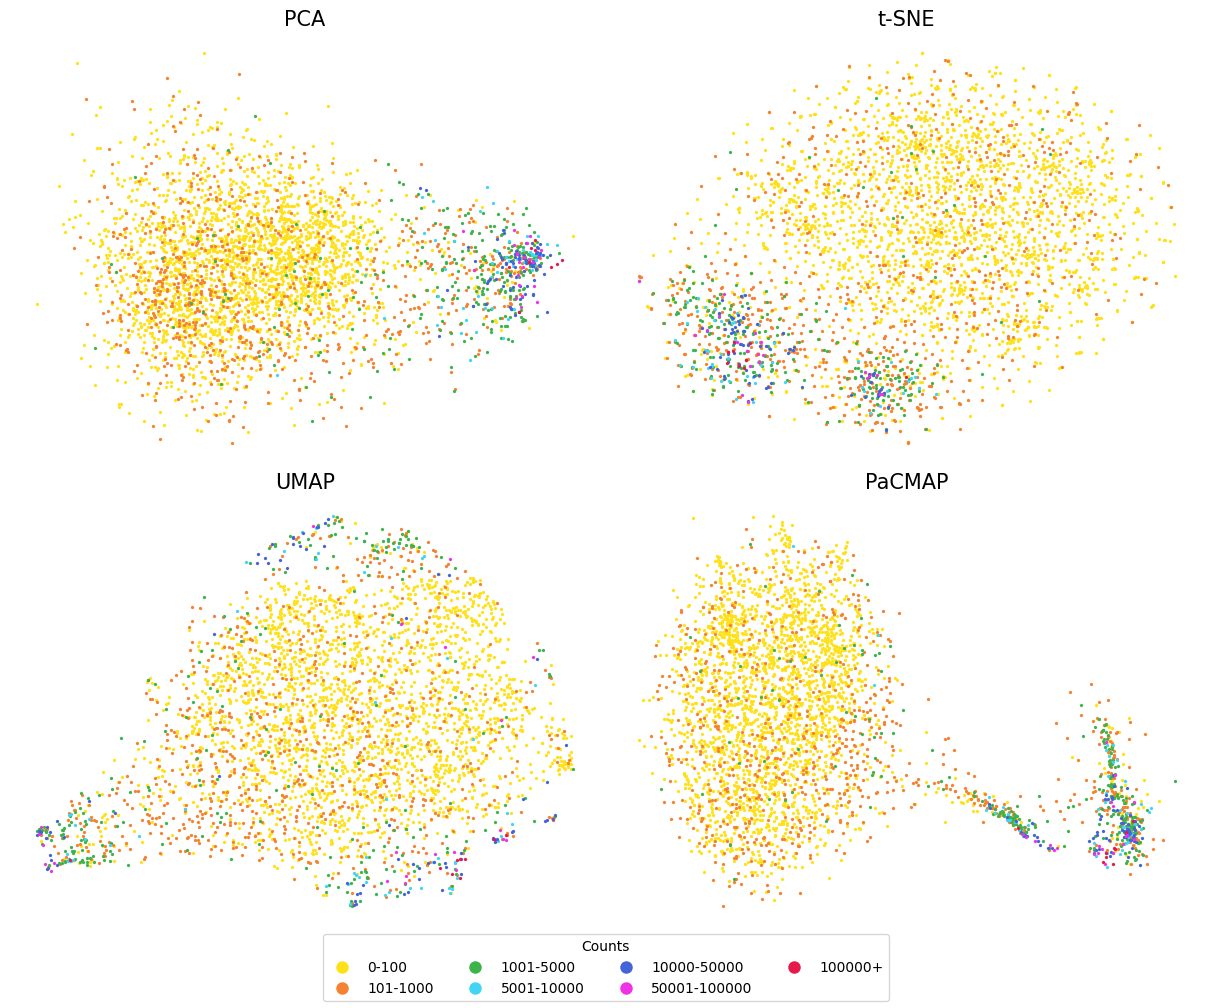

In [86]:

# Define color palette for zip codes
count_colors = {}  # Dictionary to map zip codes to colors
unique_count_codes = sorted(counts_to_labels.keys())
num_colors = len(unique_count_codes) #change this
#color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
color_palette = ['#ffe119', '#f58231', '#3cb44b', '#42d4f4', '#4363d8', '#f032e6', '#e6194b']
#print("number of unique zips: ", num_colors)

for idx, count_code in enumerate(unique_count_codes):
    count_colors[count_code] = color_palette[idx]

print(count_colors)
# Create the plots
fig, ax = plt.subplots(2, 2, figsize=(12, 10), layout="constrained")
xs = [proj_pca, proj_tsne, proj_umap, proj_pacmap]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

for row in ax:
    for col in row:
        col.set_title(ts[s], fontsize=15)

        for current_count_code in unique_count_codes:
            relevant_addresses = []
            for address, count_code in address_cluster_count.items():
                if address in journey_ids:
                    if current_count_code == count_code:
                        relevant_addresses.append(address)

            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_count_code, c=count_colors[current_count_code]
            )
        #  # Add labels to stations makes it impossible to read 
        #     for journey_id in relevant_journeys_zip:
        #         x_coord = xs[s][journey_idx[journey_id]][0]
        #         y_coord = xs[s][journey_idx[journey_id]][1]
        #         col.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed
            
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=count_colors[count_code], label=counts_to_labels[count_code]) for count_code in unique_count_codes]
fig.legend(handles= handles, loc="outside lower center", ncol=4, title='Counts')

plt.show()


In [105]:
#Metro undersøgelse


stations_with_metro = []
for location in journey_ids:
    if '(Metro)' in location:
        stations_with_metro.append(location)

City = ["Nørrebro St. (Metro)", "Nørrebros Runddel St. (Metro)", "Nuuks Plads St. (Metro)", "Axelm Møllers Have St. (Metro)", 
      "Frederiksberg St. (Metro)", "Frederiksberg Allé St. (Metro)", "Enghave Plads St. (Metro)", "København H St. (Metro)", "København H (Metro)",
      "Rådhuspladsen St. (Metro)", "Gammel Strand St. (Metro)", "Kongens Nytorv St. (Metro)", "Marmorkirken St. (Metro)",
       "Østerport St. (Metro)", "Trianglen St. (Metro)", "Poul Henningsens Plads St. (Metro)", "Vibenhus Runddel St. (Metro)",
        "Skjolds Plads St. (Metro)", "Nordhavn St. (Metro)", "Orientkaj St. (Metro)"]

M1_2 = ["Vanløse St. (Metro)", "Flintholm St. (Metro)", "Lindevang St. (Metro)", "Fasanvej St. (Metro)", 
      "Frederiksberg St. (Metro)", "Forum St. (Metro)", "Nørreport St. (Metro)", "Kongens Nytorv St. (Metro)",
      "Christianshavn St. (Metro)"]
M1 = ["Islands Brygge St. (Metro)", "DR Byen St. (Metro)", "Sundby St. (Metro)", "Bella Center St. (Metro)", "Ørestad St. (Metro)", "Vestamager St. (Metro)"]
M2 = ["Amagerbro St. (Metro)", "Lergravsparken St. (Metro)", "Øresund St. (Metro)",
      "Amager Strand St. (Metro)", "Femøren St. (Metro)", "Kastrup St. (Metro)", "Københavns Lufthavn St. (Metro)"]

color_to_metro= {"City": "Red", "M2": "Yellow", "M1": "Green", "M1_2": "Purple", "Metro": "Black"}

# Create the plots

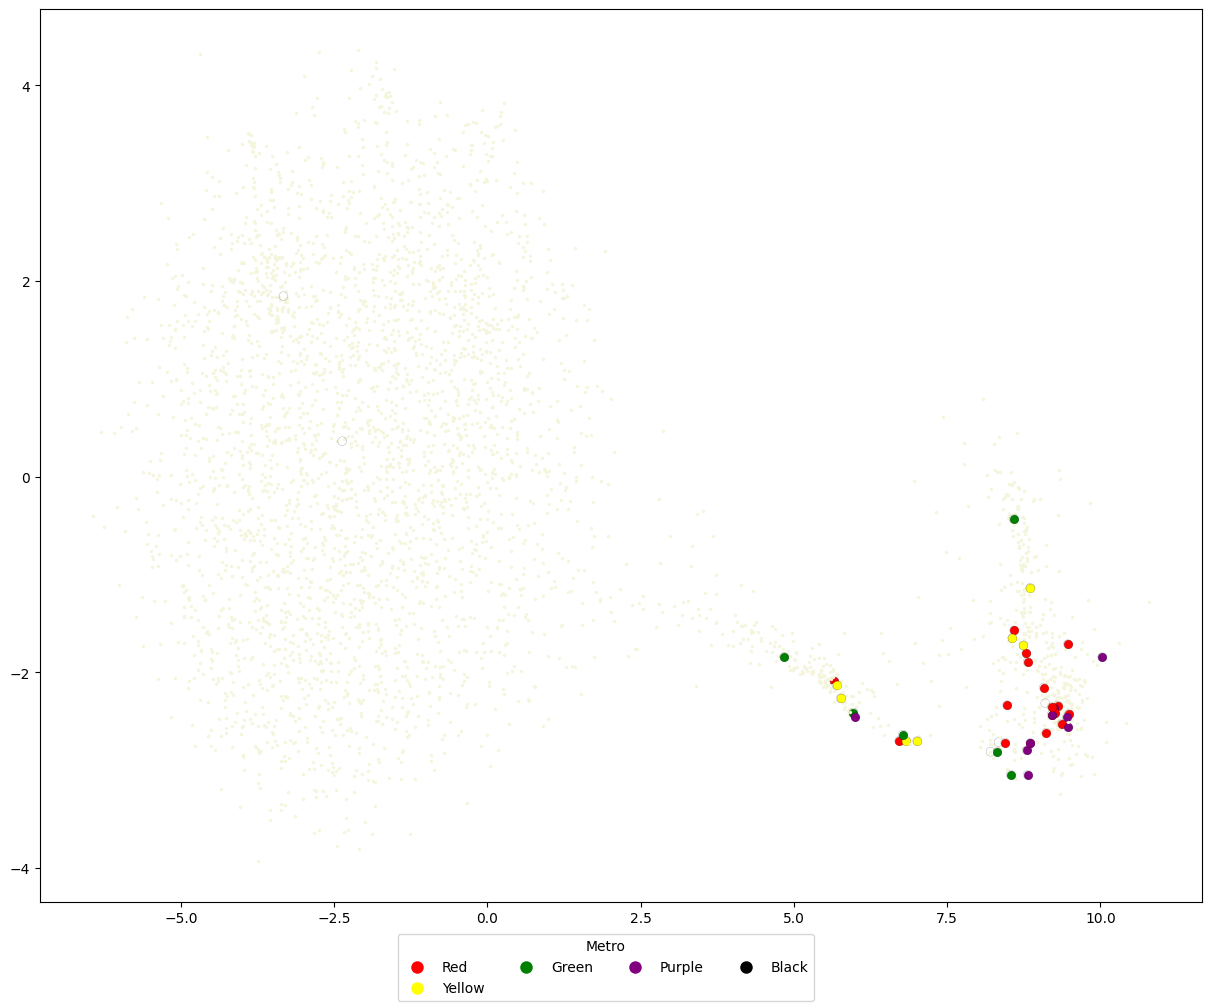

In [106]:
# Define color palette for zip codes
unique_metroes = color_to_metro.keys()
color_palette = ["Red", "Yellow", "Green", "Purple", "Black"]
colors = {}
for idx, metro in enumerate(unique_metroes):
    colors[metro] = color_palette[idx]


fig, ax = plt.subplots(1, 1, figsize=(12, 10), layout="constrained")


for current_count_code in unique_count_codes:
    relevant_addresses = []
    for address, count_code in address_cluster_count.items():
        if address in journey_ids:
            if current_count_code == count_code:
                relevant_addresses.append(address)

    relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
    #plot all without metro
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id not in stations_with_metro],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id not in stations_with_metro],
        lw=0.1, s=5, label=current_count_code, facecolor='beige'
    )

    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in stations_with_metro],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in stations_with_metro],
        lw=0.1, s=40, label=current_count_code, edgecolors='black', facecolor='none'
    )

    #Plot all city
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in City],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in City],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Red', label="City"
    )

    #Plot all m1_2
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in M1_2],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in M1_2],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Purple', label="M1_2"
    )

    #Plot all m2
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in M2],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in M2],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Yellow', label="M2"
    )

      #Plot all m1
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in M1],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in M1],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Green', label="M1"
    )


# for journey_id in stations_with_metro:
#     x_coord = proj_pacmap[journey_idx[journey_id]][0]
#     y_coord = proj_pacmap[journey_idx[journey_id]][1]
#     plt.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=colors[metro], label=color_to_metro[metro]) for metro in unique_metroes]
fig.legend(handles= handles, loc="outside lower center", ncol=4, title='Metro')

plt.show()

In [119]:
kbh_vector = model.wv['København H']
kbh__metro_vector = model.wv['København H (Metro)']
nørreport_vector = model.wv['Nørreport St.']

result = kbh__metro_vector - kbh_vector + nørreport_vector
model.wv.similar_by_vector(result)

[('Nørreport St.', 0.6902011036872864),
 ('København H (Metro)', 0.6248850226402283),
 ('Nørreport St. (Metro)', 0.5882662534713745),
 ('Frederiksborggade', 0.4681228697299957),
 ('Nørre Voldgade', 0.46488064527511597),
 ('Nørre Farimagsgade', 0.43996739387512207),
 ('Stampesgade', 0.43698200583457947),
 ('Greve St.', 0.41916316747665405),
 ('Reventlowsgade', 0.4155936539173126),
 ('Hedehusene St.', 0.39974889159202576)]

In [115]:
count_m_st_kbh = 0
count_m_kbh = 0
for seq in sequences:
    for place in seq:
        if 'København H St. (Metro)' in place:
            count_m_st_kbh += 1
        if 'København H (Metro)' in place:
            count_m_kbh += 1

print(count_m_st_kbh)
print(count_m_kbh)

179
115010


In [122]:
kbh_vector = model_50_100.wv['København H']
kbh__metro_vector = model_50_100.wv['København H (Metro)']
nørreport_vector = model_50_100.wv['Nørreport St.']

result = kbh__metro_vector - kbh_vector + nørreport_vector
model_50_100.wv.similar_by_vector(result)

[('Nørreport St.', 0.694098949432373),
 ('København H (Metro)', 0.6604334712028503),
 ('Greve St.', 0.5535091161727905),
 ('Nørreport St. (Metro)', 0.5386367440223694),
 ('København H St. (Metro)', 0.49509957432746887),
 ('Nørre Voldgade', 0.4905354976654053),
 ('Hareskov St.', 0.4750269055366516),
 ('Station Vesterbro', 0.4749649465084076),
 ('Nordhavn', 0.4677644670009613),
 ('Kavalergangen', 0.4623272120952606)]

In [123]:
kbh_vector = model_2000_300.wv['København H']
kbh__metro_vector = model_2000_300.wv['København H (Metro)']
nørreport_vector = model_2000_300.wv['Nørreport St.']

result = kbh__metro_vector - kbh_vector + nørreport_vector
model_2000_300.wv.similar_by_vector(result)

[('København H (Metro)', 0.6519349217414856),
 ('Nørreport St.', 0.6447868347167969),
 ('Nørreport St. (Metro)', 0.3782993257045746),
 ('Nørre Voldgade', 0.325791597366333),
 ('Nørre Farimagsgade', 0.31466910243034363),
 ('Station Vesterbro', 0.30100035667419434),
 ('København H St. (Metro)', 0.2876145839691162),
 ('Scandic Nørreport', 0.27987831830978394),
 ('Rådhuspladsen St. (Metro)', 0.27008387446403503),
 ('Næstved St.', 0.26836103200912476)]

In [127]:
kbh_vector = model_5_100.wv['København H']
kbh__metro_vector = model_5_100.wv['København H (Metro)']
nørreport_vector = model_5_100.wv['Nørreport St.']

result = kbh__metro_vector - kbh_vector + nørreport_vector
model_5_100.wv.similar_by_vector(result)

[('Nørreport St.', 0.7784194350242615),
 ('København H (Metro)', 0.7162572741508484),
 ('Nørre Voldgade', 0.7132539749145508),
 ('København H St. (Metro)', 0.702221155166626),
 ('Frederiksborggade', 0.6910284757614136),
 ('Nørreport St. (Metro)', 0.6841326355934143),
 ('Store Kongensgade', 0.6756613850593567),
 ('Webersgade', 0.6723543405532837),
 ('Reverdilsgade', 0.6665148138999939),
 ('Linnésgade', 0.6664074659347534)]

In [130]:
kbh_vector = model_2_100.wv['København H']
kbh__metro_vector = model_2_100.wv['København H (Metro)']
nørreport_vector = model_2_100.wv['Nørreport St.']

result = kbh__metro_vector - kbh_vector + nørreport_vector
model_2_100.wv.similar_by_vector(result)

[('Nørreport St.', 0.8495565056800842),
 ('Nørreport St. (Metro)', 0.800645112991333),
 ('Nørre Voldgade', 0.7935420274734497),
 ('Webersgade', 0.7671999335289001),
 ('Frederiksborggade', 0.7629517316818237),
 ('Trianglen', 0.7587027549743652),
 ('Sølvtorvet', 0.7571277022361755),
 ('Reventlowsgade', 0.7501713037490845),
 ('Store Kongensgade', 0.7475204467773438),
 ('Suensonsgade', 0.7449963688850403)]

In [137]:
kbh_vector = model_1_100.wv['København H']
kbh__metro_vector = model_1_100.wv['København H (Metro)']
nørreport_vector = model_1_100.wv['Nørreport St.']

result = kbh__metro_vector - kbh_vector + nørreport_vector
model_1_100.wv.similar_by_vector(result)

[('Nørreport St.', 0.8613949418067932),
 ('Sølvtorvet', 0.8146847486495972),
 ('Nørreport St. (Metro)', 0.8018662333488464),
 ('Kongens Nytorv', 0.7972455620765686),
 ('Kongens Nytorv St.', 0.7882603406906128),
 ('Reventlowsgade', 0.7849178314208984),
 ('Trianglen St.', 0.7818055748939514),
 ('Nørre Voldgade', 0.769027590751648),
 ('Webersgade', 0.7683433890342712),
 ('Georg Brandes Plads', 0.7680462002754211)]

In [138]:
kbh_vector = model_10_100.wv['København H']
kbh__metro_vector = model_10_100.wv['København H (Metro)']
nørreport_vector = model_10_100.wv['Nørreport St.']

result = kbh__metro_vector - kbh_vector + nørreport_vector
model_10_100.wv.similar_by_vector(result)

[('Nørreport St.', 0.7597514986991882),
 ('København H (Metro)', 0.7156818509101868),
 ('København H St. (Metro)', 0.6610440611839294),
 ('Reverdilsgade', 0.6351752281188965),
 ('Brolæggerstræde', 0.6273306608200073),
 ('Frederiksborggade', 0.6164356470108032),
 ('Nørreport St. (Metro)', 0.6153437495231628),
 ('Tom Kristensens Vej', 0.6134889721870422),
 ('Nørre Voldgade', 0.611677885055542),
 ('Steenstrups Alle', 0.6080369353294373)]

In [143]:
n_vector = model_1_100.wv['Nørreport St.']
model_1_100.wv.similar_by_vector(n_vector)

[('Nørreport St.', 1.0),
 ('Nørreport St. (Metro)', 0.8475301265716553),
 ('Nørre Voldgade', 0.8321118354797363),
 ('Nørre Farimagsgade', 0.8210781812667847),
 ('Kongens Nytorv St.', 0.8132573962211609),
 ('Frederiksborggade', 0.8044821619987488),
 ('Sølvtorvet', 0.778220534324646),
 ('Kongens Nytorv', 0.7647490501403809),
 ('Georg Brandes Plads', 0.7647091150283813),
 ('Suensonsgade', 0.7621084451675415)]

In [142]:
n_vector_10 = model_10_100.wv['Nørreport St.']
model_10_100.wv.similar_by_vector(n_vector_10)

[('Nørreport St.', 1.0),
 ('Nørre Voldgade', 0.739865779876709),
 ('Nørreport St. (Metro)', 0.7370263338088989),
 ('Linnésgade', 0.7115475535392761),
 ('Frederiksborggade', 0.7045254707336426),
 ('Scandic Nørreport', 0.7037196159362793),
 ('Kultorvet', 0.6994065642356873),
 ('Fiolstræde', 0.6571033596992493),
 ('Larslejsstræde', 0.6295334696769714),
 ('Brolæggerstræde', 0.6267983317375183)]